In [ ]:
!pip install deepface
!pip install pinecone-text
!pip install pinecone-client

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basics
import os
import time
import glob
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# progress
from tqdm import tqdm

# face recognition
from deepface import DeepFace

# ML
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Vector DB
from google.colab import userdata
from pinecone import Pinecone, ServerlessSpec

24-08-02 14:28:55 - Directory /root/.deepface created
24-08-02 14:28:55 - Directory /root/.deepface/weights created


In [4]:
# import our data
!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

!unzip -q family_photos.zip

family_photos.zip   100%[===================>] 774.04K  --.-KB/s    in 0.04s   


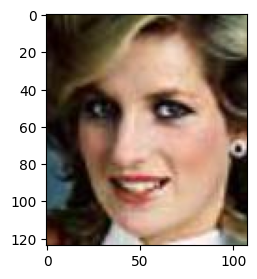

In [5]:
def show_img(image):
  img = plt.imread(image)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('/content/family/mom/P04407_face2.jpg')

# Setting up VectorDB

In [6]:
# setting up pinecone.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    print("GPU not available")
    print('=' * 50)
else:
    print("GPU available\n\n")
    print('=' * 50)

# access pinecone apikey
pinecone = Pinecone(api_key=userdata.get("PINECONE_API_KEY"))
INDEX_NAME = "facial-similarity-search-data-index"

# delete existing index, if exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    print(f"Index {INDEX_NAME} already exists")
    print('=' * 50)
    pinecone.delete_index(INDEX_NAME)
    print(f"Index {INDEX_NAME} deleted")
else:
    print(f"Index {INDEX_NAME} does not exist")

GPU available


Index facial-similarity-search-data-index does not exist


In [7]:
# Create a new index with the specified name, dimension, and metric
pinecone.create_index(
    name=INDEX_NAME,
    dimension= 128,  # model embedding dimensions
    metric="cosine",  # search metric
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

pinecone_index = pinecone.Index(INDEX_NAME)
print(f'Index Created: \n----------------------------\n{INDEX_NAME}\n----------------------------')
print(pinecone_index)

Index Created: 
----------------------------
facial-similarity-search-data-index
----------------------------


### Create Embedding of Images using DeepFace

In [8]:
# generate_vectors processes all images within the family directory structure (mom, dad, child),
# generates their face embeddings using the DeepFace library, and writes these embeddings to the vectors.vec file.

MODEL = "Facenet"

def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      files = glob.glob(f'family/{person}/*')
      for file in tqdm(files):
        try:
          embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

  0%|          | 0/78 [00:00<?, ?it/s]

24-08-02 14:29:33 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
  1%|          | 1.05M/92.2M [00:00<00:10, 9.09MB/s]
  3%|▎         | 3.15M/92.2M [00:00<00:05, 15.2MB/s]
  8%|▊         | 7.34M/92.2M [00:00<00:03, 26.3MB/s]
 12%|█▏        | 11.0M/92.2M [00:00<00:02, 28.7MB/s]
 23%|██▎       | 21.5M/92.2M [00:00<00:01, 48.1MB/s]
 35%|███▍      | 32.0M/92.2M [00:00<00:00, 62.6MB/s]
 46%|████▌     | 42.5M/92.2M [00:00<00:00, 74.4MB/s]
 64%|██████▍   | 59.2M/92.2M [00:00<00:00, 101MB/s] 
100%|██████████| 92.2M/92.2M [00:01<00:00, 81.6MB/s]
100%|██████████| 93/93 [00:24<00:00,  3.75it/s]


In [9]:
!head -5 vectors.vec

mom:P12012_face0.jpg:[-0.6013938188552856, -0.5881083011627197, 0.4999048411846161, -0.7892537117004395, -0.6679479479789734, 0.026460615918040276, 0.1531745344400406, -0.06511282920837402, -0.2675993740558624, -0.26020488142967224, 0.7496795654296875, 0.2566203474998474, 0.4833372235298157, 0.44399169087409973, 0.07037955522537231, -0.09928891062736511, 1.7412997484207153, -2.079671621322632, 0.18470829725265503, 0.19835114479064941, -0.7715660333633423, 0.13172590732574463, -1.1562325954437256, 0.45604607462882996, 0.5857518911361694, 0.5008839964866638, 1.4730781316757202, 0.33993273973464966, -0.2564825415611267, -0.7079415321350098, -0.012379966676235199, 0.33342844247817993, -0.23777589201927185, 0.6755826473236084, 0.5255724191665649, 0.48557817935943604, 0.3742968738079071, -0.6374590396881104, 0.18488983809947968, -0.3300904929637909, -0.27900609374046326, 0.5285736918449402, -0.319256991147995, 0.4807519316673279, -0.7934613823890686, -1.211287260055542, 0.18492497503757477, 

### Plot the Data of Images

In [10]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [11]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5,
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 10996.10it/s]


transform 70 vectors


241it [00:00, 8265.42it/s]


transform 93 vectors


241it [00:00, 8140.74it/s]


transform 78 vectors


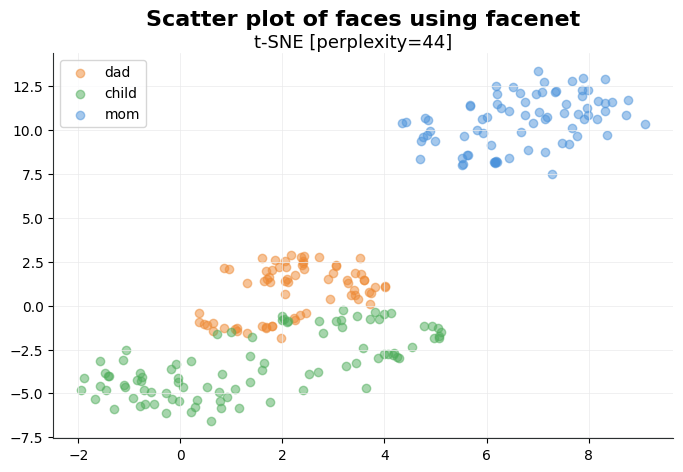

In [12]:
# Key parameter of t-SNE plot is preplexity,
# which represents the number of neighbours
# each data point has in the higher dimensional space
plot_tsne(44, 'facenet')

# Store Embeddings in Pinecone

In [13]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        pinecone_index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:29,  8.20it/s]


In [15]:
pinecone_index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 249}},
 'total_vector_count': 249}

### Lets Calculate the Similarity Scores

In [16]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [17]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 3510.61it/s]


DAD --------------------


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]




dad AVG: 0.4055693215699999
MOM --------------------


100%|██████████| 10/10 [00:00<00:00, 10.81it/s]



mom AVG: 0.37183719871600013


In [18]:
### Check the Matching Images

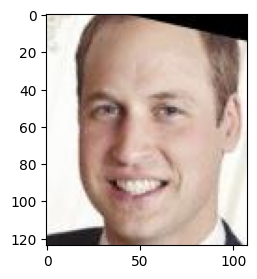

In [19]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [20]:
#Now find closest given we know dad is "most similar"
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5034329891204834, 1.1029359102249146, -0.8480637073516846, -0.7365098595619202, 0.7583200931549072, 0.4852716624736786, 0.7298256754875183, 1.4870914220809937, -0.11666880548000336, -0.8492722511291504, 0.3556518256664276, -1.2881261110305786, -0.5964645743370056, -1.1971149444580078, -0.17281821370124817, -0.7226589918136597, -1.3601897954940796, -3.014230728149414, -0.4974597692489624, -0.14029906690120697, -0.28008243441581726, -0.29536888003349304, -0.3175617754459381, -0.5717961192131042, -0.4404006898403168, -0.06698179990053177, 1.3667570352554321, 0.20050859451293945, -0.6121870875358582, 0.714701771736145, -1.5885088443756104, -0.09048807621002197, -1.8738330602645874, -0.6179010272026062, 0.38070282340049744, -0.14031770825386047, -1.378591775894165, -1.4838498830795288, 1.5449626445770264, -0.37778565287590027, -0.8945382237434387, -1.3211246728897095, -2.653660297393799, -0.43419137597084045, 2.1085562705993652, -1.689763069152832, 1.4459582567214966, 1.1110566854476929,

In [22]:
query_response = pinecone_index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [23]:
print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.437612146,
              'values': []},
             {'id': 'dad-P11969_face7.jpg',
              'metadata': {'file': 'P11969_face7.jpg', 'person': 'dad'},
              'score': 0.372992367,
              'values': []},
             {'id': 'dad-P11910_face1.jpg',
              'metadata': {'file': 'P11910_face1.jpg', 'person': 'dad'},
              'score': 0.364743292,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}


In [24]:
photo = query_response['matches'][0]['metadata']['file']

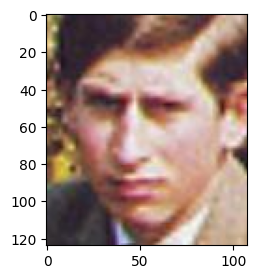

In [25]:
show_img(f'family/dad/{photo}')